Note: This notebook is an alternative to [this article](https://rpubs.com/tomytjandra/PCA-before-classification) for PCA with the Python programming language.

# PCA before Classification

## Libraries 

In [87]:
import numpy as np # data processing
import pandas as pd # data processing
import matplotlib.pyplot as plt # visualization
import plotly.express as px
import plotly.io as pio # render ploty

import statsmodels.api as sm # modelling
from sklearn.preprocessing import StandardScaler # scaling
from sklearn.decomposition import PCA # pca
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score # metric evaluation

pio.renderers.default='notebook_connected'
pd.set_option('display.max_columns', 100)

## Business Question

- **Objective**: Create a classification model to predict whether an employee will resign or not.
- **PCA function**: Pre-processing data before classification models

>We will apply PCA to the train data, then the test data will be transformed using eigenvectors that have been learned from the train data.

## Read Data 

In [2]:
attrition = pd.read_csv("data_input/attrition.csv", sep=';')

attrition.head()

,attrition,age,business_travel,daily_rate,department,distance_from_home,education,education_field,employee_count,employee_number,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over_18,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,standard_hours,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
0,yes,41,travel_rarely,1102,sales,1,2,life_sciences,1,1,2,female,94,3,2,sales_executive,4,single,5993,19479,8,y,yes,11,3,1,80,0,8,0,1,6,4,0,5
1,no,49,travel_frequently,279,research_development,8,1,life_sciences,1,2,3,male,61,2,2,research_scientist,2,married,5130,24907,1,y,no,23,4,4,80,1,10,3,3,10,7,1,7
2,yes,37,travel_rarely,1373,research_development,2,2,other,1,4,4,male,92,2,1,laboratory_technician,3,single,2090,2396,6,y,yes,15,3,2,80,0,7,3,3,0,0,0,0
3,no,33,travel_frequently,1392,research_development,3,4,life_sciences,1,5,4,female,56,3,1,research_scientist,3,married,2909,23159,1,y,yes,11,3,3,80,0,8,3,3,8,7,3,0
4,no,27,travel_rarely,591,research_development,2,1,medical,1,7,1,male,40,3,1,laboratory_technician,2,married,3468,16632,9,y,no,12,3,4,80,1,6,3,3,2,2,2,2


## Data Inspection

### Predictor

Inspect the number of unique values and data types for each column.

In [3]:
# prints information about attrition DataFrame 
attrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   attrition                   1470 non-null   object
 1   age                         1470 non-null   int64 
 2   business_travel             1470 non-null   object
 3   daily_rate                  1470 non-null   int64 
 4   department                  1470 non-null   object
 5   distance_from_home          1470 non-null   int64 
 6   education                   1470 non-null   int64 
 7   education_field             1470 non-null   object
 8   employee_count              1470 non-null   int64 
 9   employee_number             1470 non-null   int64 
 10  environment_satisfaction    1470 non-null   int64 
 11  gender                      1470 non-null   object
 12  hourly_rate                 1470 non-null   int64 
 13  job_involvement             1470 non-null   int6

In [4]:
# column list
cat_cols = attrition.select_dtypes('object').columns

# change data types 
attrition[cat_cols] = attrition[cat_cols].astype('category') 

# sanity check
attrition.dtypes

attrition                     category
age                              int64
business_travel               category
daily_rate                       int64
department                    category
distance_from_home               int64
education                        int64
education_field               category
employee_count                   int64
employee_number                  int64
environment_satisfaction         int64
gender                        category
hourly_rate                      int64
job_involvement                  int64
job_level                        int64
job_role                      category
job_satisfaction                 int64
marital_status                category
monthly_income                   int64
monthly_rate                     int64
num_companies_worked             int64
over_18                       category
over_time                     category
percent_salary_hike              int64
performance_rating               int64
relationship_satisfaction

In [5]:
# descriptive statistic
attrition.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
daily_rate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
distance_from_home,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
employee_count,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
employee_number,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
environment_satisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
hourly_rate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
job_involvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
job_level,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


In [6]:
# Count number of distinct elements on each columns
pd.DataFrame(attrition.nunique()).T

,attrition,age,business_travel,daily_rate,department,distance_from_home,education,education_field,employee_count,employee_number,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over_18,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,standard_hours,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
0,2,43,3,886,3,29,5,6,1,1470,4,2,71,4,5,9,4,3,1349,1427,10,1,2,15,2,4,1,4,40,7,4,37,19,16,18


Columns to delete:

- The `employee_number` column is not suitable to be a predictor because it is unique for each row.
- The `employee_count`, `over_18`, and `standard_hours` columns are not suitable as predictors because they only have 1 unique value.

In [7]:
# drop columns
attrition.drop(columns=['employee_number', 'employee_count', 'over_18', 'standard_hours'], inplace=True)

### Target

Check target proportions

In [8]:
pd.crosstab(index = attrition.attrition,
           columns = 'prop',
           normalize = True).round(2)

col_0,prop
attrition,
no,0.84
yes,0.16


> The proportions are slightly imbalanced. At the Data Preparation stage, we will try to do upsampling.

## One Hot Encoding

In [9]:
cat_cols = attrition.select_dtypes('category').columns
cat_cols = cat_cols.delete(0) # delete target index 

In [10]:
attrition_enc = pd.get_dummies(data = attrition, 
                                columns = cat_cols,
                                drop_first = True)

attrition_enc.head()

,attrition,age,daily_rate,distance_from_home,education,environment_satisfaction,hourly_rate,job_involvement,job_level,job_satisfaction,monthly_income,monthly_rate,num_companies_worked,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager,business_travel_travel_frequently,business_travel_travel_rarely,department_research_development,department_sales,education_field_life_sciences,education_field_marketing,education_field_medical,education_field_other,education_field_technical_degree,gender_male,job_role_human_resources,job_role_laboratory_technician,job_role_manager,job_role_manufacturing_director,job_role_research_director,job_role_research_scientist,job_role_sales_executive,job_role_sales_representative,marital_status_married,marital_status_single,over_time_yes
0,yes,41,1102,1,2,2,94,3,2,4,5993,19479,8,11,3,1,0,8,0,1,6,4,0,5,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True
1,no,49,279,8,1,3,61,2,2,2,5130,24907,1,23,4,4,1,10,3,3,10,7,1,7,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False
2,yes,37,1373,2,2,4,92,2,1,3,2090,2396,6,15,3,2,0,7,3,3,0,0,0,0,False,True,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,True,True
3,no,33,1392,3,4,4,56,3,1,3,2909,23159,1,11,3,3,0,8,3,3,8,7,3,0,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True
4,no,27,591,2,1,1,40,3,1,2,3468,16632,9,12,3,4,1,6,3,3,2,2,2,2,False,True,True,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False


In [25]:
attrition_enc.shape

(1470, 45)

## Cross Validation

Before doing PCA, do cross-validation first. Cross-validation divides data into a training set for the modeling process and a testing set for evaluation.

In [11]:
from sklearn.model_selection import train_test_split

# Memisahkan prediktor dan target
attrition_x = attrition_enc
attrition_y = attrition_enc.attrition

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(attrition_x, 
                                                   attrition_y,
                                                   test_size = 0.25,
                                                   random_state = 13,
                                                   stratify=attrition.attrition)

In [12]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (1102, 45)
X_test: (368, 45)
y_train: (1102,)
y_test: (368,)


## Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [14]:
# subset kolom numerik
num_cols = attrition.select_dtypes('number').columns

In [15]:
# transform
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

In [26]:
X_train_scaled.shape

(1102, 23)

## PCA 

In [55]:
pca = PCA(n_components=0.9)

X_train_pca = pd.DataFrame(pca.fit_transform(X_train_scaled), 
                          columns=pca.get_feature_names_out(),
                          index = X_train.index)
X_train_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15
371,-1.857282,-0.842399,0.458070,0.186417,-1.206126,0.402194,-0.116637,-1.234278,-1.039757,-1.142285,1.550747,1.370181,-0.868142,1.300317,0.235058,1.729571
1002,-0.361670,-1.056632,-0.507331,1.579841,-0.265683,-0.303142,1.371314,-0.311854,-0.462799,-0.761155,0.704837,-0.733791,-0.658223,-1.425285,-0.948797,0.367853
1299,-0.407799,-0.858443,0.511024,0.363132,-0.809517,1.137523,-1.163772,-1.254940,0.935502,-0.343752,0.065409,0.177337,0.115521,0.283333,-0.004821,-0.123321
1118,-3.039158,1.984498,1.842304,0.427993,1.380700,0.633294,-0.314911,1.188854,1.364215,0.584670,0.878191,-2.115366,-0.243517,-0.059043,0.648293,0.951472
1391,-1.552986,-1.314837,0.345230,-0.084918,0.673186,0.302056,0.613718,1.630836,1.069998,1.663361,-1.523093,0.694796,-0.331060,2.121014,0.097137,0.103523


In [56]:
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled), 
                          columns=pca.get_feature_names_out(),
                          index=X_test.index)
X_test_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15
784,2.297816,1.627406,-0.847646,1.259691,-0.485651,-0.047164,1.471543,1.980126,-0.970801,1.038566,0.322572,-0.142139,0.397348,-1.355830,0.624990,0.482486
1233,-1.151051,0.822738,-1.512834,0.068680,-1.460328,0.536715,1.043332,0.087713,1.701922,0.558370,-0.298662,0.765456,-0.442474,-1.107277,-1.390532,0.791016
176,-2.196989,0.061585,-0.732660,0.627110,0.673189,-1.503529,-0.801062,0.353809,0.832921,-0.639724,-0.100913,-2.619445,-1.028078,-0.933451,0.077386,0.438951
1214,1.356391,0.513884,-0.004328,-1.025745,-0.643671,0.596180,-0.651596,-0.305706,-0.109368,-0.345600,-0.449876,-2.373118,-0.452560,-0.522346,0.317177,0.363377
1217,-1.682622,0.430639,-0.534387,-0.559289,-0.411255,-0.081577,0.196162,-1.807397,-0.612647,-0.635475,-0.054226,-1.135322,0.307819,-0.574082,-1.374645,-0.674760


### Merge PC variable and categorical variables 

In [58]:
cat_cols = X_train.select_dtypes('bool').columns

attrition_train = pd.concat([X_train[cat_cols], X_train_pca], axis=1, join='inner')
attrition_train.head()

,business_travel_travel_frequently,business_travel_travel_rarely,department_research_development,department_sales,education_field_life_sciences,education_field_marketing,education_field_medical,education_field_other,education_field_technical_degree,gender_male,job_role_human_resources,job_role_laboratory_technician,job_role_manager,job_role_manufacturing_director,job_role_research_director,job_role_research_scientist,job_role_sales_executive,job_role_sales_representative,marital_status_married,marital_status_single,over_time_yes,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15
371,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,-1.857282,-0.842399,0.458070,0.186417,-1.206126,0.402194,-0.116637,-1.234278,-1.039757,-1.142285,1.550747,1.370181,-0.868142,1.300317,0.235058,1.729571
1002,True,False,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,-0.361670,-1.056632,-0.507331,1.579841,-0.265683,-0.303142,1.371314,-0.311854,-0.462799,-0.761155,0.704837,-0.733791,-0.658223,-1.425285,-0.948797,0.367853
1299,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.407799,-0.858443,0.511024,0.363132,-0.809517,1.137523,-1.163772,-1.254940,0.935502,-0.343752,0.065409,0.177337,0.115521,0.283333,-0.004821,-0.123321
1118,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,-3.039158,1.984498,1.842304,0.427993,1.380700,0.633294,-0.314911,1.188854,1.364215,0.584670,0.878191,-2.115366,-0.243517,-0.059043,0.648293,0.951472
1391,False,True,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,-1.552986,-1.314837,0.345230,-0.084918,0.673186,0.302056,0.613718,1.630836,1.069998,1.663361,-1.523093,0.694796,-0.331060,2.121014,0.097137,0.103523


In [59]:
attrition_train.shape

(1102, 37)

In [60]:
cat_cols = X_test.select_dtypes('bool').columns

attrition_test = pd.concat([X_test[cat_cols], X_test_pca], axis=1, join="inner")
attrition_test.head()

,business_travel_travel_frequently,business_travel_travel_rarely,department_research_development,department_sales,education_field_life_sciences,education_field_marketing,education_field_medical,education_field_other,education_field_technical_degree,gender_male,job_role_human_resources,job_role_laboratory_technician,job_role_manager,job_role_manufacturing_director,job_role_research_director,job_role_research_scientist,job_role_sales_executive,job_role_sales_representative,marital_status_married,marital_status_single,over_time_yes,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15
784,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,2.297816,1.627406,-0.847646,1.259691,-0.485651,-0.047164,1.471543,1.980126,-0.970801,1.038566,0.322572,-0.142139,0.397348,-1.355830,0.624990,0.482486
1233,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,-1.151051,0.822738,-1.512834,0.068680,-1.460328,0.536715,1.043332,0.087713,1.701922,0.558370,-0.298662,0.765456,-0.442474,-1.107277,-1.390532,0.791016
176,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,-2.196989,0.061585,-0.732660,0.627110,0.673189,-1.503529,-0.801062,0.353809,0.832921,-0.639724,-0.100913,-2.619445,-1.028078,-0.933451,0.077386,0.438951
1214,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,1.356391,0.513884,-0.004328,-1.025745,-0.643671,0.596180,-0.651596,-0.305706,-0.109368,-0.345600,-0.449876,-2.373118,-0.452560,-0.522346,0.317177,0.363377
1217,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,False,-1.682622,0.430639,-0.534387,-0.559289,-0.411255,-0.081577,0.196162,-1.807397,-0.612647,-0.635475,-0.054226,-1.135322,0.307819,-0.574082,-1.374645,-0.674760


From the output above, it is known that the numerical variable is a PC, which summarizes at least 90% of the variance of the initial data. Next, the training and test data are ready for the modeling stage.

**Recap:**

- Attrition initial data dimensions: 26 numeric and 9 categorical (total: 35)
- Data dimensions before PCA (removing 4 columns): 23 numeric and 8 categorical (total: 31)
- Data dimensions after PCA: 16 numeric and 8 categorical (total: 24)
- PCA reduces 23 numerical columns to 16 columns by summarizing at least 90% of the variance of the initial data

## Modeling

Now that we have reduced the dimensionality of the data using PCA, we can train a model. We are trying to use the Random Forest model to get prediction results that are as accurate as possible and currently do not require model interpretation. 

In [61]:
# import library
from sklearn.ensemble import RandomForestClassifier

# model intialize 
attrition_rf = RandomForestClassifier(random_state=13, 
                                   oob_score = True)

# model training
attrition_rf.fit(attrition_train , y_train) 

RandomForestClassifier(oob_score=True, random_state=13)

## Predict

In [100]:
attrition_prediction_train = attrition_rf.predict(attrition_train)

In [65]:
attrition_prediction = attrition_rf.predict(attrition_test)

## Model Evaluation

- Positive Class: `attrition` = "yes"
- False Positive Case: Employees who do not actually resign are predicted to resign
- False Negative Case: Employees who actually resign are predicted not to resign

> *For example, all employees who are predicted to resign will have their performance re-evaluated and there is the possibility of increasing the employee's benefits. Meanwhile, for those who are predicted not to resign, no treatment will be carried out. In this case, we want to minimize False Negative cases. Therefore, we want the recall to be as high as possible.*

In [66]:
# confussion matrix
pd.crosstab(attrition_prediction, y_test)

attrition,no,yes
row_0,,
no,305,56
yes,4,3


In [101]:
print('Accuracy score: ', accuracy_score(y_train, attrition_prediction_train))
print('Precision score: ', precision_score(y_train, attrition_prediction_train, pos_label='yes'))
print('Recall score: ', recall_score(y_train, attrition_prediction_train, pos_label='yes'))
print('F1 score: ', f1_score(y_train, attrition_prediction_train, pos_label='yes'))

Accuracy score:  1.0
Precision score:  1.0
Recall score:  1.0
F1 score:  1.0


In [76]:
print('Accuracy score: ', accuracy_score(y_test, attrition_prediction))
print('Precision score: ', precision_score(y_test, attrition_prediction, pos_label='yes'))
print('Recall score: ', recall_score(y_test, attrition_prediction, pos_label='yes'))
print('F1 score: ', f1_score(y_test, attrition_prediction, pos_label='yes'))

Accuracy score:  0.8369565217391305
Precision score:  0.42857142857142855
Recall score:  0.05084745762711865
F1 score:  0.09090909090909091


In [78]:
# OOB score
attrition_rf.oob_score_

0.8656987295825771

In [85]:
# variable importance
var_importance = \
pd.Series(
    attrition_rf.feature_importances_, # sumbu y
    index=attrition_train.columns # sumbu x 
    ).sort_values(ascending=False).tail(10) # mengurutkan

In [102]:
# plotly version
fig = px.bar(var_importance, orientation='h')
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

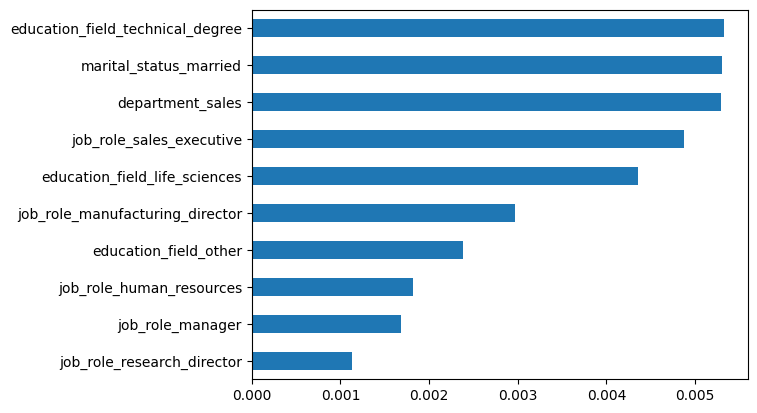

In [90]:
# matplotlib version
var_importance.plot(kind='barh').invert_yaxis()

## Conclusion

The resulting Random Forest model is still overfitted because the performance on the train data is perfect, but it is still not satisfactory on the test data. The focus of this article is to provide an example of how PCA can be implemented before using a supervised learning model, in this case, classification.